In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Embedding, LayerNormalization, MultiHeadAttention, Flatten
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer

#from functions import *

2023-05-14 12:46:10.897341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#import nltk
#nltk.download()

In [3]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin', engine ='python', header=None)
df.columns=['target', 'id', 'date', 'flag', 'user', 'text']
df = df.sample(n = 50000)

In [4]:
print(df.head())

         target          id                          date      flag  \
448597        0  2069036499  Sun Jun 07 15:08:52 PDT 2009  NO_QUERY   
1593484       4  2191944643  Tue Jun 16 06:14:45 PDT 2009  NO_QUERY   
1551233       4  2183971031  Mon Jun 15 15:14:13 PDT 2009  NO_QUERY   
248515        0  1982733209  Sun May 31 11:47:40 PDT 2009  NO_QUERY   
1103687       4  1971067015  Sat May 30 06:06:57 PDT 2009  NO_QUERY   

                  user                                               text  
448597      allyannaaa                        Where is my football head?   
1593484    arengolucky  @parawhorextwerd i have my earbuds on now, lis...  
1551233  tweeteradder4  @loveshooter Get 100 followers a day using www...  
248515     TNAaddicted                                     no new emails   
1103687    m1chellelim  @monica899  my friend was part of the Santacru...  


In [5]:
X = df['text']
labels = df['target']
labels[labels == 4] = 1

/tmp/ipykernel_51069/3478844043.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[labels == 4] = 1


<Axes: >

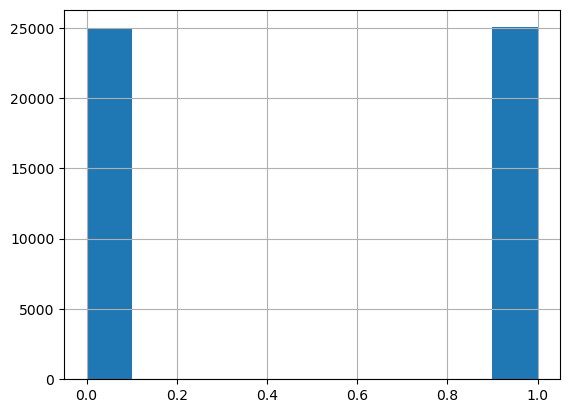

In [6]:
labels.hist()

In [7]:
print(len(labels))

50000


In [8]:
# Create a tokenizer to convert words to indices
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [9]:
l=[]
for review in sequences:
    l.append(len(review))

35


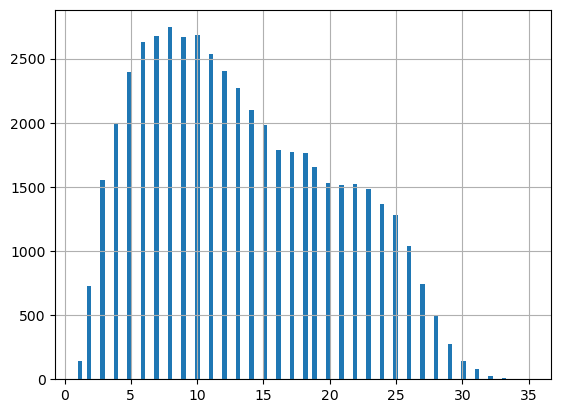

In [10]:
pd.Series(l).hist(bins=100)
print(max(l))

In [11]:
# Convert the tweets to sequences of indices
sequences = tokenizer.texts_to_sequences(X)

# Pad the sequences to a fixed length
max_len = 50
padded_sequences = pad_sequences(sequences, maxlen=max_len)


In [12]:
# Determine the padded positions
padded_positions = np.equal(padded_sequences, 0)

# Create the attention mask matrix
attention_mask = np.ones_like(padded_sequences)

# Mask the padded positions
attention_mask[padded_positions] = 0

In [13]:
print(padded_sequences, attention_mask, labels)

[[    0     0     0 ...     5  1545   304]
 [    0     0     0 ...   312    14   118]
 [    0     0     0 ...   105   565  1025]
 ...
 [    0     0     0 ...  2997  6765   176]
 [    0     0     0 ...    65     7 60128]
 [    0     0     0 ...   424    75    43]] [[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]] 448597     0
1593484    1
1551233    1
248515     0
1103687    1
          ..
1223504    1
1138082    1
961490     1
1183482    1
979233     1
Name: target, Length: 50000, dtype: int64


In [14]:
dataset = tf.data.Dataset.from_tensor_slices((padded_sequences, attention_mask, labels))

def map_func(sequence, attention, labels):
    return {'sequence': sequence, 'mask': attention}, labels

dataset = dataset.map(map_func)

for i in dataset.take(1):
    print(i)


({'sequence': <tf.Tensor: shape=(50,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  206,    8,    5, 1545,  304], dtype=int32)>, 'mask': <tf.Tensor: shape=(50,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1], dtype=int32)>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


2023-05-14 12:46:35.729237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 12:46:35.730664: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
dataset = dataset.batch(32)

In [16]:
ds_len = len(df)
print('dataset length: ', ds_len)

train_size = 0.8
train = dataset.take(round(ds_len*train_size))
test = dataset.skip(round(ds_len*train_size))

del dataset

dataset length:  50000


In [17]:
from transformers import TFAutoModel

/home/joe/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [19]:
print(labels)

448597     0
1593484    1
1551233    1
248515     0
1103687    1
          ..
1223504    1
1138082    1
961490     1
1183482    1
979233     1
Name: target, Length: 50000, dtype: int64


In [20]:
input_seq = tf.keras.layers.Input(shape=(max_len,), name='sequence', dtype='int32')
mask = tf.keras.layers.Input(shape=(max_len,), name='mask', dtype='int32')

embeddings = bert(input_seq, attention_mask=mask)[0]

X = tf.keras.layers.MaxPooling1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(32, activation='relu')(X)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(X)

model = tf.keras.Model(inputs = [input_seq, mask], outputs=y)

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 mask (InputLayer)              [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['sequence[0][0]',               
                                thPoolingAndCrossAt               'mask[0][0]']                   
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                            

In [21]:
model.layers[2].trainable = False
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 mask (InputLayer)              [(None, 50)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['sequence[0][0]',               
                                thPoolingAndCrossAt               'mask[0][0]']                   
                                tentions(last_hidde                                               
                                n_state=(None, 50,                                            

In [22]:
optimizer = tf.keras.optimizers.Adam(0.01)
loss = tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])


In [23]:
history = model.fit(train,validation_data=test,epochs=3)

Epoch 1/3


ValueError: in user code:

    File "/home/joe/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/joe/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/joe/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/joe/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/joe/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/home/joe/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/joe/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/joe/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/joe/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/joe/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/keras/backend.py", line 5680, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 25, 1) vs (None,)).
